In [150]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

In [16]:
import torch
df = pd.read_csv('raw_data.csv')

X = torch.tensor(df.loc[:, ['blue_0_rank', 'blue_1_rank', 'blue_2_rank', 'blue_3_rank', 'blue_4_rank', 'red_0_rank', 'red_1_rank', 'red_2_rank', 'red_3_rank', 'red_4_rank']].values, dtype=torch.long)
y = torch.tensor(df['winner'].values, dtype=torch.long)

n = int(0.9*len(y)) # first 90% will be train, rest val
X_train_data = X[:n]
X_val_data = X[n:]
Y_train_data = y[:n]
Y_val_data = y[n:]
print(f'In total, there is {X.shape[0]} raw data match, seperated into {X_train_data.shape[0]} test data and {X_val_data.shape[0]} validation')

Features (X): torch.Size([6113, 10, 10])
Targets (Y): torch.Size([6113])
In total, there is 6113 raw data match, seperated into 5501 test data and 612 validation


In [17]:
team1_count = (Y_train_data == 0).sum()
team2_count = (Y_train_data == 1).sum()
print(f"Team 1 win samples: {team1_count}, Team 2 win samples: {team2_count}")


Team 1 win samples: 2714, Team 2 win samples: 2787


In [153]:
batch_size = 32

def get_batch(split):
    # generate a small batch of data of inputs x and targets y
    data = X_train_data if split == 'train' else X_val_data
    label = Y_train_data if split == 'train' else Y_val_data
    ix = torch.randint(len(data), (batch_size,))
    x = torch.stack([data[i] for i in ix])
    y = torch.stack([label[i] for i in ix])
    return x, y

In [154]:
xb, yb = get_batch('train')
print(f'inputs shape:{list(xb.shape)}')
print(xb[:5])
print(f'targets shape:{list(yb.shape)}')
print(yb[:5])

print('----')

for b in range(batch_size//4): # batch dimension
    inp = xb[b]
    target = yb[b]
    print(f'When input is {inp} the target: {target}')

inputs shape:[32, 10]
tensor([[ 3,  7,  6,  5,  3,  5,  5,  0,  6,  6],
        [ 9,  9, 11, 13, 11, 13, 12, 12, 11,  9],
        [ 8,  5,  8,  0,  0,  6,  4,  7,  6,  6],
        [24, 23, 24, 24, 23, 22, 23, 24, 23, 23],
        [ 8,  7, 10,  8, 12,  9,  9, 11,  9,  9]])
targets shape:[32]
tensor([1, 1, 0, 0, 1])
----
When input is tensor([3, 7, 6, 5, 3, 5, 5, 0, 6, 6]) the target: 1
When input is tensor([ 9,  9, 11, 13, 11, 13, 12, 12, 11,  9]) the target: 1
When input is tensor([8, 5, 8, 0, 0, 6, 4, 7, 6, 6]) the target: 0
When input is tensor([24, 23, 24, 24, 23, 22, 23, 24, 23, 23]) the target: 0
When input is tensor([ 8,  7, 10,  8, 12,  9,  9, 11,  9,  9]) the target: 1
When input is tensor([0, 5, 0, 8, 6, 5, 6, 5, 3, 4]) the target: 0
When input is tensor([17, 17, 14, 19, 18, 17, 17, 18, 16, 19]) the target: 0
When input is tensor([10, 10, 11,  0, 11, 11, 10, 12, 10,  9]) the target: 1


In [155]:
import torch
import torch.nn as nn
from torch.nn import functional as F

n_embd = 16
n_layer = 2
unique_rank = list(set(X.flatten().tolist()))
dropout = 0.0
learning_rate = 1e-3
max_iters = 5_000
eval_interval = 100
eval_iters = 200

class ValorantOucomesMatchModel(nn.Module):

    def __init__(self, n_embd):
        super().__init__()
        self.rank_embedding_table = nn.Embedding(len(unique_rank), n_embd)
        self.blocks = nn.Sequential(*[FeedFoward(n_embd) for _ in range(n_layer)])
        self.ln_f1 = nn.LayerNorm(n_embd) 
        self.ln_f2 = nn.LayerNorm(n_embd) 
        self.ln_f3 = nn.LayerNorm(n_embd) 
        self.lm_head = nn.Linear(n_embd, 2)
    
    def forward(self, idx, targets = None):
        B, T = idx.shape

        # B -> Batch size 
        # T -> nb Player 
        # C -> Embedding size

        x = self.rank_embedding_table(idx) # (B,T,C)
        x = torch.mean(self.ln_f1(x),dim=1)
        x = self.blocks(self.ln_f2(x)) # (B,C)
        logits = self.lm_head(self.ln_f3(x)) # (B,2)

        if targets is None:
            loss = None
        else:
            B, C = logits.shape
            loss = F.cross_entropy(logits, targets)

        return logits, loss

class FeedFoward(nn.Module):
    """ a simple linear layer followed by a non-linearity """

    def __init__(self, n_embd):
        super().__init__()
        self.net = nn.Sequential(
            nn.LayerNorm(n_embd),
            nn.Linear(n_embd, 4 * n_embd),
            nn.ReLU(),
            nn.Linear(4 * n_embd, n_embd),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        return x + self.net(x) # residual connection

@torch.no_grad()
def estimate_loss(model):
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out

In [156]:
model = ValorantOucomesMatchModel(n_embd)
print(sum(p.numel() for p in model.parameters()), 'parameters')

4866 parameters


In [157]:
estimate_loss(model)

{'train': tensor(0.8448), 'val': tensor(0.8774)}

step 4999: train loss 0.6677, val loss 0.7389: 100%|██████████| 5000/5000 [00:20<00:00, 238.87it/s]


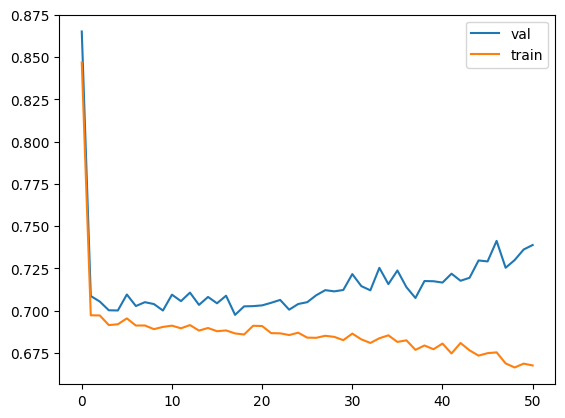

In [158]:
# create a PyTorch optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
pbar = tqdm(total=max_iters)
val_loss = []
train_loss = []

for iter in range(max_iters):

    # every once in a while evaluate the loss on train and val sets
    if iter % eval_interval == 0 or iter == max_iters - 1:
        losses = estimate_loss(model)
        # print(f"step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")
        pbar.set_description(f"step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")
        val_loss.append(losses['val']), train_loss.append(losses['train'])
    pbar.update(1)

    # sample a batch of data
    xb, yb = get_batch('train')

    # evaluate the loss
    logits, loss = model(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

pbar.close()

plt.plot(val_loss, label="val")
plt.plot(train_loss, label="train")
plt.legend()
plt.show()

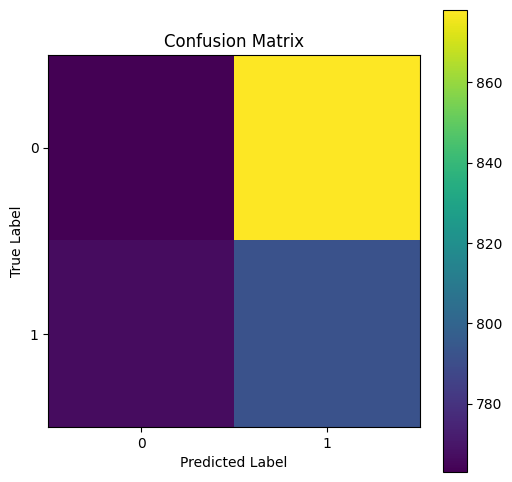

Confusion Matrix:
 tensor([[763., 878.],
        [767., 792.]])
Average Accuracy: 0.4859


In [212]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

# Initialize confusion matrix and other variables
conf_matrix = torch.zeros(2, 2)
num_eval_iters = 100

# Evaluation loop
with torch.no_grad():
    model.eval()  # Set model to evaluation mode
    for _ in range(num_eval_iters):
        # Get validation batch
        X_batch, Y_batch = get_batch('val')
        
        # Forward pass
        logits, _ = model(X_batch, Y_batch)
        probs = F.softmax(logits, dim=-1)
        # argmax
        # predictions = probs.argmax(dim=1)      
        #  
        # multinomial
        predictions = torch.multinomial(probs, num_samples=1)  

        # random
        # predictions = torch.randint_like(predictions,2) 
                
        # Update confusion matrix
        for true_label, predicted_label in zip(Y_batch.view(-1), predictions):
            conf_matrix[true_label.long(), predicted_label.long()] += 1
    
    model.train()  # Reset model to training mode

# Visualization of the confusion matrix
plt.figure(figsize=(6, 6))
plt.imshow(conf_matrix, interpolation='nearest')
plt.colorbar()
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks(range(2))
plt.yticks(range(2))
plt.grid(False)
plt.show()

# Print results
print("Confusion Matrix:\n", conf_matrix)
accuracy = (conf_matrix[0,0] + conf_matrix[1,1]) / conf_matrix.sum()
print(f"Average Accuracy: {accuracy:.4f}")


# New attempt with more More feature for each player

In [80]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

In [81]:
import torch
df = pd.read_csv('raw_data_enhance.csv')

features = df.iloc[:, 1:-1]  # All columns except the last one
targets = df.iloc[:, -1]    # The last column

X = torch.tensor(features.values, dtype=torch.long)  # Convert features to a long tensor
Y = torch.tensor(targets.values, dtype=torch.long)      # Convert targets to a long tensor (for classification)

B, F = X.shape
X = X.view(B,10,-1)

# Verify the tensors
print("Features (X):", X.shape)
print("Targets (Y):", Y.shape)

n = int(0.9*len(Y)) # first 90% will be train, rest val
X_train_data = X[:n]
X_val_data = X[n:]
Y_train_data = Y[:n]
Y_val_data = Y[n:]
print(f'In total, there is {X.shape[0]} raw data match, seperated into {X_train_data.shape[0]} test data and {X_val_data.shape[0]} validation')

Features (X): torch.Size([6113, 10, 10])
Targets (Y): torch.Size([6113])
In total, there is 6113 raw data match, seperated into 5501 test data and 612 validation


In [82]:
team1_count = (Y_train_data == 0).sum()
team2_count = (Y_train_data == 1).sum()
print(f"Team 1 win samples: {team1_count}, Team 2 win samples: {team2_count}")


Team 1 win samples: 2714, Team 2 win samples: 2787


In [83]:
X[:1]

tensor([[[   8, 2897,    8,   19,    5,   47,    4,    3, 2024, 3551],
         [   0, 5627,   22,   14,    1,   48,   22,    2, 4209, 2559],
         [   6, 5874,   20,   16,    6,   48,   12,    5, 3883, 3457],
         [   8, 3325,   12,   16,    1,   28,   12,    0, 2606, 3009],
         [  10, 5344,   19,   18,   10,   41,   17,    1, 3376, 3598],
         [   9, 6564,   24,   17,    6,   71,    6,    1, 3996, 3512],
         [   6, 2575,    7,   17,    8,   26,    5,    5, 1927, 3105],
         [   8, 5831,   20,   17,    9,   59,    7,   18, 3678, 3403],
         [   8, 3719,   12,   17,    4,   35,   10,   12, 2578, 3383],
         [   8, 5468,   20,   13,    7,   45,   15,    4, 4000, 2700]]])

In [84]:
batch_size = 32

def get_batch(split):
    # generate a small batch of data of inputs x and targets y
    data = X_train_data if split == 'train' else X_val_data
    label = Y_train_data if split == 'train' else Y_val_data
    ix = torch.randint(len(data), (batch_size,))
    x = torch.stack([data[i] for i in ix])
    y = torch.stack([label[i] for i in ix])
    return x, y

In [85]:
xb, yb = get_batch('train')
print(f'inputs shape:{list(xb.shape)}')
print(xb[:1])
print(f'targets shape:{list(yb.shape)}')
print(yb[:1])

inputs shape:[32, 10, 10]
tensor([[[  12, 3116,   13,   10,    3,   28,    6,    3, 1818, 2155],
         [  15, 3543,   13,   12,    9,   23,   10,    3, 2326, 2498],
         [  18, 5120,   19,    9,    4,   49,   11,    5, 3531, 1960],
         [  19, 5832,   21,   12,    5,   60,   14,    5, 3439, 2312],
         [  14, 2739,    9,   10,    8,   20,    7,    9, 1696, 1804],
         [  19, 3318,   11,   14,    3,   47,    8,    9, 2154, 2504],
         [  15, 2452,    7,   18,    5,   19,    7,    3, 1779, 2781],
         [   9, 4294,   15,   14,    1,   47,    5,   10, 2518, 2400],
         [  16, 2751,    8,   17,    4,   29,    8,    1, 1879, 2934],
         [  15, 3531,   12,   13,    0,   43,    4,    6, 2442, 2234]]])
targets shape:[32]
tensor([0])


In [86]:
import torch
import torch.nn as nn
from torch.nn import functional as F

nb_features = 10
n_layer = 4
dropout = 0.1
learning_rate = 1e-3
max_iters = 100_000
eval_interval = 100
eval_iters = 200

class PlayerLayer(nn.Module):
    def __init__(self, nb_features):
        super().__init__()
        self.net = nn.Sequential(
            nn.LayerNorm(nb_features),
            nn.Linear(nb_features, 4 * nb_features),
            nn.ReLU(),
            nn.Linear(4 * nb_features, nb_features),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        return x + self.net(x) # residual connection

class TeamLayer(nn.Module):
    def __init__(self):
        super().__init__()
        

    def forward(self):
        pass

class ValorantOucomesMatchModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.player_layer = nn.Sequential(*[PlayerLayer(10) for _ in range(n_layer)])
        self.team_layer = nn.Sequential(*[PlayerLayer(10) for _ in range(n_layer)])
        self.ln1 = nn.LayerNorm(nb_features)
        self.lm_head = nn.Linear(nb_features, 2)

    def forward(self, players_info, targets=None):
        B, T, C = players_info.shape

        x = self.player_layer(players_info.float())
        team_A_mean = torch.mean(x[:,:5],dim=1)
        team_B_mean = torch.mean(x[:,5:],dim=1)

        x = self.team_layer(team_A_mean) + self.team_layer(team_B_mean)
        logits = self.lm_head(self.ln1(x))

        if targets is None:
            loss = None
        else:
            B, C = logits.shape
            loss = F.cross_entropy(logits, targets)

        return logits, loss


@torch.no_grad()
def estimate_loss(model):
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out


In [87]:
model = ValorantOucomesMatchModel()
print(sum(p.numel() for p in model.parameters()), 'parameters')

7002 parameters


In [88]:
xb, yb = get_batch('train')
model(xb.float())[0].shape

torch.Size([32, 2])

In [89]:
estimate_loss(model)

{'train': tensor(0.7312), 'val': tensor(0.7188)}

step 99999: train loss 0.6844, val loss 0.6898: 100%|██████████| 100000/100000 [42:15<00:00, 39.44it/s]   


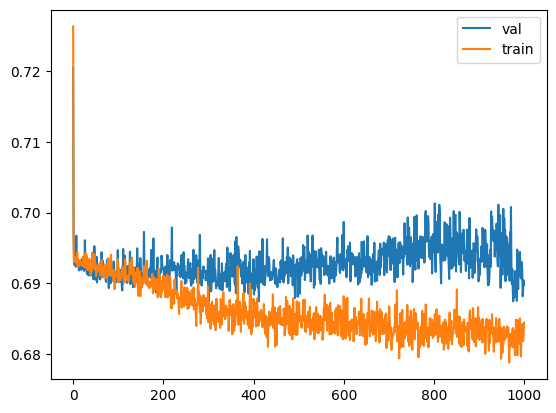

In [90]:
# create a PyTorch optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
pbar = tqdm(total=max_iters)
val_loss = []
train_loss = []

for iter in range(max_iters):

    # every once in a while evaluate the loss on train and val sets
    if iter % eval_interval == 0 or iter == max_iters - 1:
        losses = estimate_loss(model)
        # print(f"step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")
        pbar.set_description(f"step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")
        val_loss.append(losses['val']), train_loss.append(losses['train'])
    pbar.update(1)

    # sample a batch of data
    xb, yb = get_batch('train')

    # evaluate the loss
    logits, loss = model(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

pbar.close()

plt.plot(torch.tensor(val_loss[1:]).view(-1,10).mean(dim=1), label="val")
plt.plot(torch.tensor(train_loss[1:]).view(-1,10).mean(dim=1), label="train")
plt.legend()
plt.show()

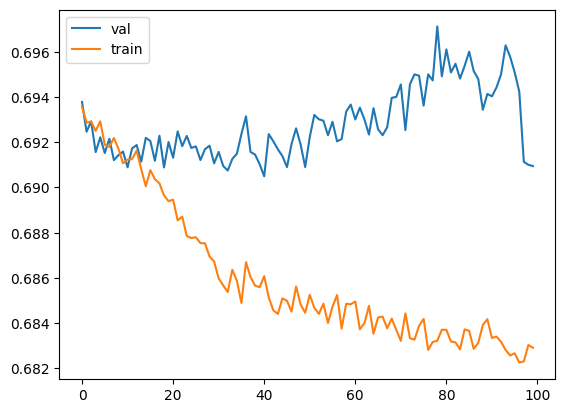

In [95]:
plt.plot(torch.tensor(val_loss[1:]).view(-1,10).mean(dim=1), label="val")
plt.plot(torch.tensor(train_loss[1:]).view(-1,10).mean(dim=1), label="train")
plt.legend()
plt.show()

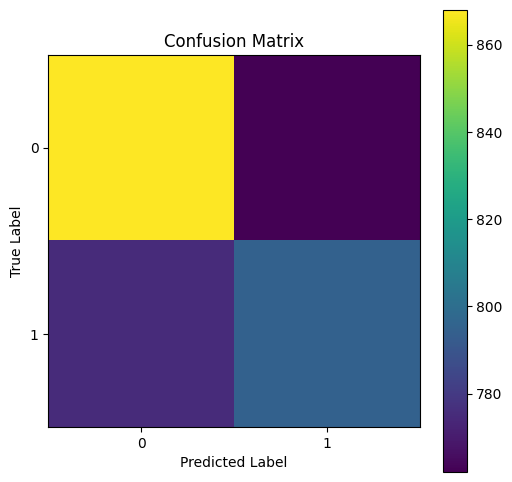

Confusion Matrix:
 tensor([[868., 762.],
        [775., 795.]])
Average Accuracy: 0.5197


In [92]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

# Initialize confusion matrix and other variables
conf_matrix = torch.zeros(2, 2)
num_eval_iters = 100

# Evaluation loop
with torch.no_grad():
    model.eval()  # Set model to evaluation mode
    for _ in range(num_eval_iters):
        # Get validation batch
        X_batch, Y_batch = get_batch('val')
        
        # Forward pass
        logits, _ = model(X_batch, Y_batch)
        probs = F.softmax(logits, dim=-1)
        # argmax
        # predictions = probs.argmax(dim=1)      
        #  
        # multinomial
        predictions = torch.multinomial(probs, num_samples=1)  

        # random
        # predictions = torch.randint_like(predictions,2) 
                
        # Update confusion matrix
        for true_label, predicted_label in zip(Y_batch.view(-1), predictions):
            conf_matrix[true_label.long(), predicted_label.long()] += 1
    
    model.train()  # Reset model to training mode

# Visualization of the confusion matrix
plt.figure(figsize=(6, 6))
plt.imshow(conf_matrix, interpolation='nearest')
plt.colorbar()
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks(range(2))
plt.yticks(range(2))
plt.grid(False)
plt.show()

# Print results
print("Confusion Matrix:\n", conf_matrix)
accuracy = (conf_matrix[0,0] + conf_matrix[1,1]) / conf_matrix.sum()
print(f"Average Accuracy: {accuracy:.4f}")
